In [111]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GroupShuffleSplit
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

## Reading

In [112]:
df = pd.read_csv("data.csv")

### Set random state

In [113]:
RANDOM_STATE = 13

## EDA

In [114]:
# MR Delay
# after how many days visit based on first visit

# EDUC
# How many years educate

# SES
# Socioeconomic Status
# 5 means LOW and 1 means HIGH?

# MMSE
# Mini‐Mental State Examination

# CDR
# Clinical Dementia Rating

# eTIV
# Estimated total intracranial volume

# nWBV
# Normalize Whole Brain Volume

# ASF
# Atlas Scaling Factor

In [115]:
df.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,Sex,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [116]:
df.tail()

,Subject ID,MRI ID,Group,Visit,MR Delay,Sex,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
368,OAS2_0185,OAS2_0185_MR2,Demented,2,842,M,R,82,16,1.0,28.0,0.5,1693,0.694,1.037
369,OAS2_0185,OAS2_0185_MR3,Demented,3,2297,M,R,86,16,1.0,26.0,0.5,1688,0.675,1.040
370,OAS2_0186,OAS2_0186_MR1,Nondemented,1,0,F,R,61,13,2.0,30.0,0.0,1319,0.801,1.331
371,OAS2_0186,OAS2_0186_MR2,Nondemented,2,763,F,R,63,13,2.0,30.0,0.0,1327,0.796,1.323
372,OAS2_0186,OAS2_0186_MR3,Nondemented,3,1608,F,R,65,13,2.0,30.0,0.0,1333,0.801,1.317


In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  373 non-null    object 
 1   MRI ID      373 non-null    object 
 2   Group       373 non-null    object 
 3   Visit       373 non-null    int64  
 4   MR Delay    373 non-null    int64  
 5   Sex         373 non-null    object 
 6   Hand        373 non-null    object 
 7   Age         373 non-null    int64  
 8   EDUC        373 non-null    int64  
 9   SES         354 non-null    float64
 10  MMSE        371 non-null    float64
 11  CDR         373 non-null    float64
 12  eTIV        373 non-null    int64  
 13  nWBV        373 non-null    float64
 14  ASF         373 non-null    float64
dtypes: float64(5), int64(5), object(5)
memory usage: 43.8+ KB


In [118]:
df.describe()

,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
count,373.000000,373.000000,373.000000,373.000000,354.000000,371.000000,373.000000,373.000000,373.000000,373.000000
mean,1.882038,595.104558,77.013405,14.597855,2.460452,27.342318,0.290885,1488.128686,0.729568,1.195461
std,0.922843,635.485118,7.640957,2.876339,1.134005,3.683244,0.374557,176.139286,0.037135,0.138092
min,1.000000,0.000000,60.000000,6.000000,1.000000,4.000000,0.000000,1106.000000,0.644000,0.876000
25%,1.000000,0.000000,71.000000,12.000000,2.000000,27.000000,0.000000,1357.000000,0.700000,1.099000
50%,2.000000,552.000000,77.000000,15.000000,2.000000,29.000000,0.000000,1470.000000,0.729000,1.194000
75%,2.000000,873.000000,82.000000,16.000000,3.000000,30.000000,0.500000,1597.000000,0.756000,1.293000
max,5.000000,2639.000000,98.000000,23.000000,5.000000,30.000000,2.000000,2004.000000,0.837000,1.587000


## Preprocessing

### Handeling SES nan values 

<AxesSubplot: >

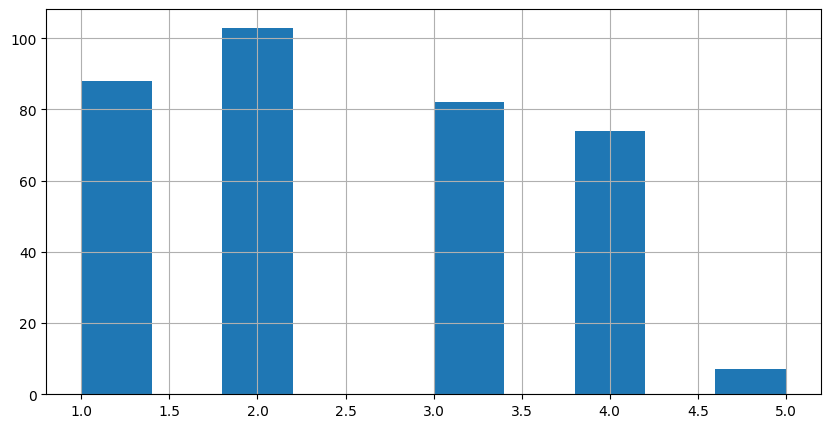

In [119]:
df.SES.hist(figsize = (10,5))

In [120]:
df.SES.mean()

2.4604519774011298

In [121]:
df.SES.unique()

array([ 2., nan,  3.,  4.,  1.,  5.])

In [122]:
# fill nan values function for SES
def fill_ses(x):
    ses = 0
    if x > 17:
        ses = 1.0
    elif (x < 17) and (x > 15):
        ses = 2.0
    elif (x < 15) and (x > 13):
        ses = 3.0
    elif (x < 13) and (x > 11):
        ses = 4.0
    else:
        ses = 5.0
    return ses

In [123]:
df.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,Sex,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [124]:
df["SES"] = df.apply(lambda x : fill_ses(x.EDUC) if pd.isna(x.SES)   else x.SES, axis = 1)

In [125]:
# convert float to int to use less memory
df["SES"] = df.SES.astype(int)

In [126]:
df.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,Sex,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,4,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,4,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,4,22.0,0.5,1698,0.701,1.034


### Handeling MMSE nan values 

<AxesSubplot: >

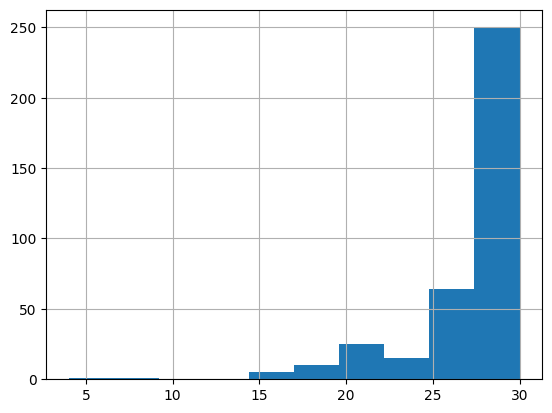

In [127]:
df.MMSE.hist()

In [128]:
df["MMSE"].mean()

27.342318059299192

In [129]:
df["MMSE"].median()

29.0

In [130]:
df[df["MMSE"].isna()]

,Subject ID,MRI ID,Group,Visit,MR Delay,Sex,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
357,OAS2_0181,OAS2_0181_MR2,Demented,2,539,F,R,75,12,4,NaN,1.0,1169,0.742,1.501
358,OAS2_0181,OAS2_0181_MR3,Demented,3,1107,F,R,77,12,4,NaN,1.0,1159,0.733,1.515


In [131]:
df[df["Group"] == "Demented"]["MMSE"].median()

26.0

In [132]:
df[df["MMSE"] < 26]["Group"].unique()

array(['Demented', 'Converted'], dtype=object)

In [133]:
df["MMSE"] = df.MMSE.fillna(df[df["Group"] == "Demented"]["MMSE"].median())

### Replace M/F values

In [134]:
df["Sex"] = np.where(df["Sex"] == "M", 1, 0)

### Drop Hand & MRI ID

In [135]:
df.drop(["Hand", "MRI ID"], axis = 1, inplace = True)

### Handeling Visits

In [136]:
# 11
df.iloc[10:13,:]

,Subject ID,Group,Visit,MR Delay,Sex,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
10,OAS2_0007,Demented,1,0,1,71,16,2,28.0,0.5,1357,0.748,1.293
11,OAS2_0007,Demented,3,518,1,73,16,2,27.0,1.0,1365,0.727,1.286
12,OAS2_0007,Demented,4,1281,1,75,16,2,27.0,1.0,1372,0.710,1.279


In [137]:
# 11
df.loc[11,'Visit'] = 2
df.loc[12,'Visit'] = 3
df.iloc[10:13,:]

,Subject ID,Group,Visit,MR Delay,Sex,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
10,OAS2_0007,Demented,1,0,1,71,16,2,28.0,0.5,1357,0.748,1.293
11,OAS2_0007,Demented,2,518,1,73,16,2,27.0,1.0,1365,0.727,1.286
12,OAS2_0007,Demented,3,1281,1,75,16,2,27.0,1.0,1372,0.710,1.279


In [138]:
# 30
df.iloc[29:33,:]

,Subject ID,Group,Visit,MR Delay,Sex,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
29,OAS2_0017,Nondemented,1,0,1,80,12,3,29.0,0.0,1783,0.752,0.985
30,OAS2_0017,Nondemented,3,617,1,81,12,3,27.0,0.5,1814,0.759,0.968
31,OAS2_0017,Nondemented,4,1861,1,85,12,3,30.0,0.0,1820,0.755,0.964
32,OAS2_0017,Nondemented,5,2400,1,86,12,3,27.0,0.0,1813,0.761,0.968


In [139]:
# 30
df.loc[30,'Visit'] = 2
df.loc[31,'Visit'] = 3
df.loc[32,'Visit'] = 4
df.iloc[29:33,:]

,Subject ID,Group,Visit,MR Delay,Sex,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
29,OAS2_0017,Nondemented,1,0,1,80,12,3,29.0,0.0,1783,0.752,0.985
30,OAS2_0017,Nondemented,2,617,1,81,12,3,27.0,0.5,1814,0.759,0.968
31,OAS2_0017,Nondemented,3,1861,1,85,12,3,30.0,0.0,1820,0.755,0.964
32,OAS2_0017,Nondemented,4,2400,1,86,12,3,27.0,0.0,1813,0.761,0.968


In [140]:
# 34
df.iloc[33:36,:]

,Subject ID,Group,Visit,MR Delay,Sex,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
33,OAS2_0018,Converted,1,0,0,87,14,1,30.0,0.0,1406,0.715,1.248
34,OAS2_0018,Converted,3,489,0,88,14,1,29.0,0.0,1398,0.713,1.255
35,OAS2_0018,Converted,4,1933,0,92,14,1,27.0,0.5,1423,0.696,1.234


In [141]:
# 34
df.loc[34,'Visit'] = 2
df.loc[35,'Visit'] = 3
df.iloc[33:36,:]

,Subject ID,Group,Visit,MR Delay,Sex,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
33,OAS2_0018,Converted,1,0,0,87,14,1,30.0,0.0,1406,0.715,1.248
34,OAS2_0018,Converted,2,489,0,88,14,1,29.0,0.0,1398,0.713,1.255
35,OAS2_0018,Converted,3,1933,0,92,14,1,27.0,0.5,1423,0.696,1.234


In [142]:
# 69
df.iloc[68:71]

,Subject ID,Group,Visit,MR Delay,Sex,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
68,OAS2_0036,Nondemented,1,0,0,69,13,4,30.0,0.0,1359,0.789,1.291
69,OAS2_0036,Nondemented,3,713,0,70,13,4,30.0,0.0,1361,0.783,1.290
70,OAS2_0036,Nondemented,4,1770,0,73,13,4,30.0,0.0,1360,0.773,1.291


In [143]:
# 69
df.loc[69,'Visit'] = 2
df.loc[70,'Visit'] = 3
df.iloc[68:71]

,Subject ID,Group,Visit,MR Delay,Sex,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
68,OAS2_0036,Nondemented,1,0,0,69,13,4,30.0,0.0,1359,0.789,1.291
69,OAS2_0036,Nondemented,2,713,0,70,13,4,30.0,0.0,1361,0.783,1.290
70,OAS2_0036,Nondemented,3,1770,0,73,13,4,30.0,0.0,1360,0.773,1.291


In [144]:
# 188
df.iloc[187:189]

,Subject ID,Group,Visit,MR Delay,Sex,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
187,OAS2_0089,Demented,1,0,1,70,12,2,29.0,0.5,1432,0.692,1.225
188,OAS2_0089,Demented,3,563,1,72,12,2,27.0,1.0,1432,0.684,1.226


In [145]:
# 188
df.loc[188,'Visit'] = 2
df.iloc[187:189]

,Subject ID,Group,Visit,MR Delay,Sex,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
187,OAS2_0089,Demented,1,0,1,70,12,2,29.0,0.5,1432,0.692,1.225
188,OAS2_0089,Demented,2,563,1,72,12,2,27.0,1.0,1432,0.684,1.226


In [146]:
# 274
df.iloc[273:275]

,Subject ID,Group,Visit,MR Delay,Sex,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
273,OAS2_0133,Converted,1,0,0,78,12,3,29.0,0.0,1475,0.731,1.190
274,OAS2_0133,Converted,3,1006,0,81,12,3,28.0,0.5,1495,0.687,1.174


In [147]:
# 274
df.loc[274,'Visit'] = 2
df.iloc[273:275]

,Subject ID,Group,Visit,MR Delay,Sex,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
273,OAS2_0133,Converted,1,0,0,78,12,3,29.0,0.0,1475,0.731,1.190
274,OAS2_0133,Converted,2,1006,0,81,12,3,28.0,0.5,1495,0.687,1.174


### Cut only firsts and seconds and third visits

In [148]:
df_copy = df.copy()

In [149]:
has_third_subject_id = df[df["Visit"] == 3]["Subject ID"].values

In [150]:
df = df[df['Subject ID'].isin(has_third_subject_id)]

In [151]:
df = df[df["Visit"] < 4]

In [152]:
df.reset_index(drop = True, inplace = True)

In [153]:
df = pd.get_dummies(df, columns = ["Visit"],prefix = "Visit")

### Replace Group values

Example of how **Converted** Group should be handeled:

- before:

    - Subject ID = OAS2_0020,Group = Converted, Visit = 1

    - Subject ID = OAS2_0020,Group = Converted, Visit = 2
 
- after:

    - Subject ID = OAS2_0020,Group = Nondemented, Visit = 1

    - Subject ID = OAS2_0020,Group = Demented, Visit = 2
 

In [154]:
df.iloc[40:45]

,Subject ID,Group,MR Delay,Sex,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,Visit_1,Visit_2,Visit_3
40,OAS2_0040,Demented,567,1,86,6,4,27.0,0.5,1320,0.724,1.329,False,True,False
41,OAS2_0040,Demented,1204,1,88,6,4,23.0,0.5,1348,0.713,1.302,False,False,True
42,OAS2_0041,Converted,0,0,71,16,1,27.0,0.0,1289,0.771,1.362,True,False,False
43,OAS2_0041,Converted,756,0,73,16,1,28.0,0.0,1295,0.768,1.356,False,True,False
44,OAS2_0041,Converted,1331,0,75,16,1,28.0,0.5,1314,0.760,1.335,False,False,True


In [155]:
def handle_converted(x):
    gp = x.Group
    v3 = x.Visit_3
    if gp == "Demented":
        return 1
    elif gp == "Nondemented":
        return 0
    else:
        if v3 == 1:
            return 1
        else:
            return 0


In [156]:
df["Group"] = df.apply(lambda x : handle_converted(x), axis = 1)

In [157]:
df.head()

,Subject ID,Group,MR Delay,Sex,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,Visit_1,Visit_2,Visit_3
0,OAS2_0002,1,0,1,75,12,4,23.0,0.5,1678,0.736,1.046,True,False,False
1,OAS2_0002,1,560,1,76,12,4,28.0,0.5,1738,0.713,1.010,False,True,False
2,OAS2_0002,1,1895,1,80,12,4,22.0,0.5,1698,0.701,1.034,False,False,True
3,OAS2_0005,0,0,1,80,12,4,28.0,0.0,1689,0.712,1.039,True,False,False
4,OAS2_0005,0,1010,1,83,12,4,29.0,0.5,1701,0.711,1.032,False,True,False


In [158]:
visit_3 = df[df["Visit_3"] == 1][["Subject ID","Group"]]
df = df.drop(visit_3.index, axis = 0).reset_index(drop = True).drop("Visit_3", axis = 1)

## Processing

### A list to remember and compare details

In [159]:
model_details = []

### Split Data

In [160]:
# GroupShuffleSplit should be used because it is important to model to learn each patient fully (all visit for each patient).
splitter = GroupShuffleSplit(test_size=.20, n_splits=1, random_state = RANDOM_STATE)

In [161]:
split = splitter.split(df, groups=df['Subject ID'])
train_indexes, test_indexes = next(split)

X_train = df.iloc[train_indexes]
X_test = df.iloc[test_indexes]

### Normalization

In [162]:
delay_scaler = MinMaxScaler()
age_scaler = MinMaxScaler()
educ_scaler = MinMaxScaler()
mmse_scaler = MinMaxScaler()
etiv_scaler = MinMaxScaler()

delay_scaler.fit(X_train["MR Delay"].to_numpy().reshape(-1,1))
age_scaler.fit(X_train["Age"].to_numpy().reshape(-1,1))
educ_scaler.fit(X_train["EDUC"].to_numpy().reshape(-1,1))
mmse_scaler.fit(X_train["MMSE"].to_numpy().reshape(-1,1))
etiv_scaler.fit(X_train["eTIV"].to_numpy().reshape(-1,1))

X_train["MR Delay"] = delay_scaler.transform(X_train["MR Delay"].to_numpy().reshape(-1,1))
X_train["Age"] = age_scaler.transform(X_train["Age"].to_numpy().reshape(-1,1))
X_train["EDUC"] = educ_scaler.transform(X_train["EDUC"].to_numpy().reshape(-1,1))
X_train["MMSE"] = mmse_scaler.transform(X_train["MMSE"].to_numpy().reshape(-1,1))
X_train["eTIV"] = etiv_scaler.transform(X_train["eTIV"].to_numpy().reshape(-1,1))

X_test["MR Delay"] = delay_scaler.transform(X_test["MR Delay"].to_numpy().reshape(-1,1))
X_test["Age"] = age_scaler.transform(X_test["Age"].to_numpy().reshape(-1,1))
X_test["EDUC"] = educ_scaler.transform(X_test["EDUC"].to_numpy().reshape(-1,1))
X_test["MMSE"] = mmse_scaler.transform(X_test["MMSE"].to_numpy().reshape(-1,1))
X_test["eTIV"] = etiv_scaler.transform(X_test["eTIV"].to_numpy().reshape(-1,1))

C:\Users\HP\AppData\Local\Temp\ipykernel_16648\1268356017.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train["MR Delay"] = delay_scaler.transform(X_train["MR Delay"].to_numpy().reshape(-1,1))
C:\Users\HP\AppData\Local\Temp\ipykernel_16648\1268356017.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train["Age"] = age_scaler.transform(X_train["Age"].to_numpy().reshape(-1,1))
C:\Users\HP\AppData\Local\Temp\ipykernel_16648\1268356017.py:15: SettingWithCopyWarning: 
A value is trying to be set on

## Train Test Final

In [163]:
y_train_final = []
for id in X_train["Subject ID"].unique():
    res = visit_3[visit_3["Subject ID"] == id]["Group"].values[0]
    y_train_final.append(res)

y_test_final = []
for id in X_test["Subject ID"].unique():
    res = visit_3[visit_3["Subject ID"] == id]["Group"].values[0]
    y_test_final.append(res)


In [164]:
y_train_super_final = pd.DataFrame({
    "Group": y_train_final
})

y_test_super_final = pd.DataFrame({
    "Group": y_test_final
})

In [165]:
X_test_final = X_test.drop(["Subject ID","Sex","EDUC","SES"], axis = 1)
X_train_final = X_train.drop(["Subject ID","Sex","EDUC","SES"], axis = 1)

In [166]:
X_train_final

,Group,MR Delay,Age,MMSE,CDR,eTIV,nWBV,ASF,Visit_1,Visit_2
2,0,0.000000,0.588235,0.866667,0.0,0.764977,0.712,1.039,True,False
3,0,0.649936,0.676471,0.933333,0.5,0.783410,0.711,1.032,False,True
4,1,0.000000,0.323529,0.866667,0.5,0.254992,0.748,1.293,True,False
5,1,0.333333,0.382353,0.800000,1.0,0.267281,0.727,1.286,False,True
6,0,0.000000,0.529412,0.933333,0.0,0.218126,0.748,1.316,True,False
...,...,...,...,...,...,...,...,...,...,...
107,0,0.117117,0.176471,1.000000,0.0,0.483871,0.740,1.165,False,True
108,1,0.000000,0.588235,0.866667,0.5,0.788018,0.711,1.030,True,False
109,1,0.541828,0.647059,0.866667,0.5,0.771121,0.694,1.037,False,True
110,0,0.000000,0.029412,1.000000,0.0,0.196621,0.801,1.331,True,False


In [167]:
rows_n = 2
X_train_super_final = np.reshape(X_train_final.to_numpy(),(X_train_final.shape[0]//2,X_train_final.shape[1],rows_n))
X_test_super_final = np.reshape(X_test_final.to_numpy(),(X_test_final.shape[0]//2,X_train_final.shape[1],rows_n))

In [168]:
X_train_super_final.shape

(44, 10, 2)

In [169]:
X_train_super_final

array([[[0, 0.0],
        [0.5882352941176472, 0.8666666666666667],
        [0.0, 0.7649769585253456],
        [0.712, 1.039],
        [True, False],
        [0, 0.6499356499356499],
        [0.6764705882352939, 0.9333333333333333],
        [0.5, 0.7834101382488479],
        [0.711, 1.032],
        [False, True]],

       [[1, 0.0],
        [0.32352941176470607, 0.8666666666666667],
        [0.5, 0.2549923195084487],
        [0.748, 1.293],
        [True, False],
        [1, 0.3333333333333333],
        [0.38235294117647056, 0.8],
        [1.0, 0.26728110599078336],
        [0.727, 1.286],
        [False, True]],

       [[0, 0.0],
        [0.5294117647058822, 0.9333333333333333],
        [0.0, 0.2181259600614438],
        [0.748, 1.316],
        [True, False],
        [0, 0.4697554697554697],
        [0.5882352941176472, 0.9333333333333333],
        [0.0, 0.20276497695852536],
        [0.738, 1.326],
        [False, True]],

       [[0, 0.0],
        [0.5882352941176472, 0.93333333333

In [170]:
X_train_super_final = X_train_super_final.astype('float32')
y_train_super_final = y_train_super_final.astype('int32')
X_test_super_final = X_test_super_final.astype('float32')
y_test_super_final = y_test_super_final.astype('int32')

### RNN LSTM

In [171]:
def build_lstm_rnn():
    lstm_rnn = tf.keras.Sequential()
    lstm_rnn.add(tf.keras.layers.LSTM(100, return_sequences = True,input_shape = (X_train_super_final.shape[1],X_train_super_final.shape[2]) ) )
    lstm_rnn.add(tf.keras.layers.LSTM(50,return_sequences = False))
    lstm_rnn.add(tf.keras.layers.Dense(1,activation = "sigmoid"))
    lstm_rnn.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])
    return lstm_rnn

Epoch 1/100
2/2 [==============================] - 4s 14ms/step - loss: 0.6906 - accuracy: 0.6364
Epoch 2/100
2/2 [==============================] - 0s 10ms/step - loss: 0.6733 - accuracy: 0.6364
Epoch 3/100
2/2 [==============================] - 0s 13ms/step - loss: 0.6597 - accuracy: 0.6364
Epoch 4/100
2/2 [==============================] - 0s 15ms/step - loss: 0.6500 - accuracy: 0.6364
Epoch 5/100
2/2 [==============================] - 0s 11ms/step - loss: 0.6357 - accuracy: 0.6364
Epoch 6/100
2/2 [==============================] - 0s 12ms/step - loss: 0.6246 - accuracy: 0.6364
Epoch 7/100
2/2 [==============================] - 0s 14ms/step - loss: 0.6102 - accuracy: 0.6364
Epoch 8/100
2/2 [==============================] - 0s 13ms/step - loss: 0.5914 - accuracy: 0.6364
Epoch 9/100
2/2 [==============================] - 0s 11ms/step - loss: 0.5665 - accuracy: 0.6591
Epoch 10/100
2/2 [==============================] - 0s 11ms/step - loss: 0.5399 - accuracy: 0.7273
Epoch 11/100
2/2 [=

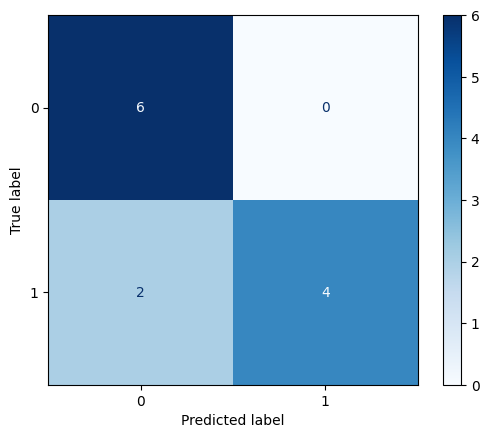

In [172]:
lstm_rnn = build_lstm_rnn()
lstm_rnn.fit(X_train_super_final, y_train_super_final, epochs = 100)
not_final_lstm_rnn_prediction = lstm_rnn.predict(X_test_super_final)
lstm_rnn_prediction = np.where(not_final_lstm_rnn_prediction > 0.5, 1, 0)
print(classification_report(y_test_super_final,lstm_rnn_prediction, target_names= ["Non-Demanted", "Demanted"]))
lstm_rnn_conf = confusion_matrix(y_test_super_final,lstm_rnn_prediction)
model_details.append(["LSTM RNN", round(f1_score(y_test_super_final,lstm_rnn_prediction, average = "weighted") * 100,4),lstm_rnn_conf[1,0]])
lstm_rnn_plot_conf = ConfusionMatrixDisplay(lstm_rnn_conf)
lstm_rnn_plot_conf.plot(cmap='Blues', values_format='d')

In [173]:
TP=lstm_rnn_conf[1,1]
FP=lstm_rnn_conf[0,1]
TN=lstm_rnn_conf[0,0]
FN=lstm_rnn_conf[1,0]
accuracy1=(TP+TN)/(TP+FP+FN+TN)
recall1=TP/(TP+FN)
percision1=TP/(TP+TN)
f1_score=(2*recall1*percision1)/(percision1+recall1)
print(round(accuracy1,2),round(recall1,2),round(percision1,2),round(f1_score,2))

0.83 0.67 0.4 0.5
